In [1]:
path = r'C:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\RESSOURCES'

In [2]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import lightgbm as lgb # MODIFICATION
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(path+r'\application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(path+r'\application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], axis=0).reset_index() # MODIFICATION
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path+r'\bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path+r'\bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path+r'\previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path+r'\POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path+r'\installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True): # FONCTION MODIFIEE POUR GERER LES COLONNES CATEGORIELLES
    cc = pd.read_csv(path+r'\credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    
    # Séparer les colonnes numériques et catégorielles
    num_cols = [col for col in cc.columns if col not in cat_cols and col != 'SK_ID_CURR' and col != 'SK_ID_PREV']
    
    # Agrégations pour colonnes numériques
    num_aggs = {}
    for col in num_cols:
        num_aggs[col] = ['min', 'max', 'mean', 'sum', 'var']
        
    # Agrégations pour colonnes catégorielles
    cat_aggs = {}
    for col in cat_cols:
        cat_aggs[col] = ['mean']  # uniquement la moyenne pour les colonnes catégorielles
    
    # Combiner les agrégations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    
    # Appliquer les agrégations séparément
    num_agg = cc[['SK_ID_CURR'] + num_cols].groupby('SK_ID_CURR').agg(num_aggs)
    cat_agg = cc[['SK_ID_CURR'] + cat_cols].groupby('SK_ID_CURR').agg(cat_aggs)
    
    # Renommer les colonnes
    num_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in num_agg.columns.tolist()])
    cat_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cat_agg.columns.tolist()])
    
    # Combiner les résultats
    cc_agg = num_agg.join(cat_agg, on='SK_ID_CURR', how='left')
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    del cc, num_agg, cat_agg
    gc.collect()
    return cc_agg

def clean_column_names(df): # FONCTION RAJOUTER POUR NETTOYER LES NOMS DE COLONNES POUR LIGHT GBM
    """
    Nettoie les noms de colonnes pour les rendre compatibles avec LightGBM
    """
    def clean_name(name):
        # Remplace les caractères spéciaux par des underscores
        import re
        name = re.sub(r'[^A-Za-z0-9_]+', '_', str(name))
        # Évite les underscores doubles
        name = re.sub(r'_+', '_', name)
        # Enlève les underscores au début et à la fin
        name = name.strip('_')
        return name
    
    df.columns = [clean_name(col) for col in df.columns]
    return df


# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Nettoyer les noms de colonnes dès le début
    df = clean_column_names(df) # AJOUT DE CETTE LIGNE
    
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = LGBMClassifier(
            n_jobs=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1
        )

        clf.fit(train_x, train_y, 
            eval_set=[(train_x, train_y), (valid_x, valid_y)],
            eval_metric='auc',
            callbacks=[
                lgb.early_stopping(stopping_rounds=200),
                lgb.log_evaluation(period=200)
            ]
        )

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False, save_df = True):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    ## AJOUT ## 
    # Sauvegarde du DataFrame avant modélisation si demandé
    if save_df:
        df.to_csv('full_dataset.csv', index=False)
        print("DataFrame complet sauvegardé dans 'full_dataset.csv'")
    ## FIN AJOUT ## 
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
    
if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        final_df = main()

# FONCTION D'UTILISATION DES MODELES

In [3]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
import os
import mlflow
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score
from sklearn.svm import LinearSVC

def train_and_evaluate_model(
    model,
    X_train_scaled, 
    X_test_scaled, 
    y_train, 
    y_test, 
    model_params={},
    seuil=0.36,
    experiment_name="Credit Scoring Model"
):
    if mlflow.active_run():
        mlflow.end_run()
    
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_name = f'{type(model).__name__}') as run:  # Simplifié ici
        # Enregistrer le type de modèle et ses paramètres
        mlflow.log_param("model_type", type(model).__name__)
        mlflow.log_params(model_params)
        mlflow.log_param("threshold", seuil)
        
        # Entraîner le modèle
        model.set_params(**model_params)
        model.fit(X_train_scaled, y_train)
        
        # Prédictions
        y_prob = model.predict_proba(X_test_scaled)
        y_pred = (y_prob[:, 1] >= seuil).astype(int)
        
        # Calculer les métriques
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'auc_score': roc_auc_score(y_test, y_prob[:, 1])
        }
        
        # Enregistrer les métriques
        mlflow.log_metrics(metrics)
        
        # Enregistrer le modèle avec un nom simplifié
        mlflow.sklearn.log_model(model, f"model_{type(model).__name__}")
        
        print(f"\nRésultats pour {type(model).__name__}:")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value:.4f}")
            
        return model, metrics, run.info.run_id

In [4]:
def clean_feature_names(X):
    import re
    # Copie du DataFrame
    X_clean = X.copy()
    
    # Nettoyer les noms de colonnes
    new_columns = {}
    for col in X_clean.columns:
        # Remplacer les caractères spéciaux par des underscores
        new_col = re.sub(r'[^A-Za-z0-9_]+', '_', str(col))
        # Éviter les underscores doubles
        new_col = re.sub(r'_+', '_', new_col)
        # Enlever les underscores au début et à la fin
        new_col = new_col.strip('_')
        new_columns[col] = new_col
    
    # Renommer les colonnes
    X_clean = X_clean.rename(columns=new_columns)
    return X_clean

def custom_credit_score(y_true, y_pred, fn_weight=10, fp_weight=1):
    # Calculer la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculer la précision et le recall avec les poids
    weighted_precision = tp / (tp + fp_weight * fp) if (tp + fp_weight * fp) > 0 else 0
    weighted_recall = tp / (tp + fn_weight * fn) if (tp + fn_weight * fn) > 0 else 0
    
    # Calculer le F1-score pondéré
    if weighted_precision + weighted_recall > 0:
        weighted_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)
    else:
        weighted_f1 = 0
        
    return weighted_f1

def train_and_evaluate_model(
    model,
    X_train_scaled, 
    X_test_scaled, 
    y_train, 
    y_test, 
    model_params={},
    seuil=0.36,
    experiment_name="Credit Scoring Model"
):
    if isinstance(model, LGBMClassifier):
        X_train_scaled = clean_feature_names(X_train_scaled)
        X_test_scaled = clean_feature_names(X_test_scaled)
        
    if mlflow.active_run():
        mlflow.end_run()
    
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_name=f"{type(model).__name__}") as run:
        mlflow.log_param("model_type", type(model).__name__)
        mlflow.log_params(model_params)
        mlflow.log_param("threshold", seuil)
        
        # Entraîner le modèle
        model.set_params(**model_params)
        model.fit(X_train_scaled, y_train)
        
        # Prédictions
        y_prob = model.predict_proba(X_test_scaled)
        y_pred = (y_prob[:, 1] >= seuil).astype(int)
        
        # Calculer les métriques
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'auc_score': roc_auc_score(y_test, y_prob[:, 1]),
            'custom_credit_score': custom_credit_score(y_test, y_pred, fn_weight=10, fp_weight=1)
        }
        
        # Enregistrer les métriques
        mlflow.log_metrics(metrics)
        
        # Enregistrer le modèle
        mlflow.sklearn.log_model(model, f"model_{type(model).__name__}")
        
        print(f"\nRésultats pour {type(model).__name__}:")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value:.4f}")
            
        return model, metrics, run.info.run_id

J'ai modifié plusieurs lignes de ce notebook du à des dépréciations depuis sa création

In [5]:
DF_results = pd.read_csv(r'C:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\submission_kernel02.csv')

In [6]:
DF_results

,SK_ID_CURR,TARGET
0,100001,0.033534
1,100005,0.146321
2,100013,0.029158
3,100028,0.036100
4,100038,0.147196
...,...,...
48739,456221,0.045465
48740,456222,0.060997
48741,456223,0.007718
48742,456224,0.025056


Les résultats obtenus sont des probabilités. Probabilités du client de ne pas rembourser le crédit

In [7]:
DF_final = pd.read_csv(r'C:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\full_dataset.csv')

In [8]:
DF_final.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356251 entries, 0 to 356250
Data columns (total 766 columns):
 #    Column                                                                 Non-Null Count   Dtype  
---   ------                                                                 --------------   -----  
 0    index                                                                  356251 non-null  int64  
 1    SK_ID_CURR                                                             356251 non-null  int64  
 2    TARGET                                                                 307507 non-null  float64
 3    CODE_GENDER                                                            356251 non-null  int64  
 4    FLAG_OWN_CAR                                                           356251 non-null  int64  
 5    FLAG_OWN_REALTY                                                        356251 non-null  int64  
 6    CNT_CHILDREN                                                      

In [9]:
DF_final = clean_feature_names(DF_final)

In [10]:
DF_final.describe()

c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWa

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT
count,356251.000000,356251.000000,307507.00000,356251.000000,356251.000000,356251.000000,356251.000000,3.562510e+05,3.562510e+05,356215.000000,...,102866.000000,103558.000000,1.035580e+05,103558.000000,103558.000000,103558.000000,103558.000000,103558.000000,103558.0,103558.000000
mean,136052.869904,278128.870078,0.08073,0.660001,0.339699,0.306764,0.414312,1.701159e+05,5.877695e+05,27425.644390,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683
std,93841.582375,102842.068890,0.27242,0.473709,0.473608,0.461151,0.720376,2.235080e+05,3.986253e+05,14732.860946,...,6110.026303,0.114345,7.659438e-05,0.109727,0.010525,0.000156,0.000846,0.031014,0.0,33.483627
min,0.000000,100001.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
25%,44532.000000,189065.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10.000000
50%,129384.000000,278129.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,22.000000
75%,218447.500000,367192.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,75.000000
max,307510.000000,456255.000000,1.00000,1.000000,1.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,...,845673.427019,1.000000,1.190476e-02,1.000000,1.000000,0.013889,0.024390,1.000000,0.0,192.000000


In [11]:
DF_final_test = DF_final.loc[DF_final['TARGET'].isna()]

In [12]:
DF_final_train = DF_final.loc[~DF_final['TARGET'].isna()]


In [13]:
DF_final_train.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307506
Data columns (total 766 columns):
 #    Column                                                                 Non-Null Count   Dtype  
---   ------                                                                 --------------   -----  
 0    index                                                                  307507 non-null  int64  
 1    SK_ID_CURR                                                             307507 non-null  int64  
 2    TARGET                                                                 307507 non-null  float64
 3    CODE_GENDER                                                            307507 non-null  int64  
 4    FLAG_OWN_CAR                                                           307507 non-null  int64  
 5    FLAG_OWN_REALTY                                                        307507 non-null  int64  
 6    CNT_CHILDREN                                                           

In [14]:
DF_final_train = DF_final_train.drop('index',axis=1)

In [15]:
DF_final_train['SK_ID_CURR'] = DF_final_train['SK_ID_CURR'].astype(int)

In [16]:
DF_final_train = DF_final_train.set_index('SK_ID_CURR')

In [17]:
DF_final_test.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 48744 entries, 307507 to 356250
Data columns (total 766 columns):
 #    Column                                                                 Non-Null Count  Dtype  
---   ------                                                                 --------------  -----  
 0    index                                                                  48744 non-null  int64  
 1    SK_ID_CURR                                                             48744 non-null  int64  
 2    TARGET                                                                 0 non-null      float64
 3    CODE_GENDER                                                            48744 non-null  int64  
 4    FLAG_OWN_CAR                                                           48744 non-null  int64  
 5    FLAG_OWN_REALTY                                                        48744 non-null  int64  
 6    CNT_CHILDREN                                                           4874

In [18]:
DF_final_test = DF_final_test.drop('index',axis=1)

In [19]:
DF_final_test['SK_ID_CURR'] = DF_final_test['SK_ID_CURR'].astype(int)

In [20]:
DF_final_test = DF_final_test.set_index('SK_ID_CURR')

In [21]:
DF_final_train.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# TRAITEMENT DES NAN


In [22]:
for col in DF_final_train.columns:
    if col != 'TARGET':
        DF_final_train.loc[DF_final_train[col].isna(), col] = DF_final_train[col].mean()

In [23]:
for col in DF_final_test.columns:
    if col != 'TARGET':
        DF_final_test.loc[DF_final_test[col].isna(), col] = DF_final_test[col].mean()

In [24]:
DF_final_train.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 100002 to 456255
Data columns (total 764 columns):
 #    Column                                                                 Non-Null Count   Dtype  
---   ------                                                                 --------------   -----  
 0    TARGET                                                                 307507 non-null  float64
 1    CODE_GENDER                                                            307507 non-null  float64
 2    FLAG_OWN_CAR                                                           307507 non-null  float64
 3    FLAG_OWN_REALTY                                                        307507 non-null  float64
 4    CNT_CHILDREN                                                           307507 non-null  float64
 5    AMT_INCOME_TOTAL                                                       307507 non-null  float64
 6    AMT_CREDIT                                                        

In [25]:
DF_final_test.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 48744 entries, 100001 to 456250
Data columns (total 764 columns):
 #    Column                                                                 Non-Null Count  Dtype  
---   ------                                                                 --------------  -----  
 0    TARGET                                                                 0 non-null      float64
 1    CODE_GENDER                                                            48744 non-null  float64
 2    FLAG_OWN_CAR                                                           48744 non-null  float64
 3    FLAG_OWN_REALTY                                                        48744 non-null  float64
 4    CNT_CHILDREN                                                           48744 non-null  float64
 5    AMT_INCOME_TOTAL                                                       48744 non-null  float64
 6    AMT_CREDIT                                                             4874

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Séparation features (X) et target (y)
X = DF_final_train.drop('TARGET', axis=1)
y = DF_final_train['TARGET']


In [27]:
# 1. D'abord vérifions les types de données
print("Types de données dans X :")
print(X.dtypes)

# 2. Sélectionnons uniquement les colonnes numériques
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

# 3. Maintenant vérifions les infinis dans les colonnes numériques
print("\nColonnes avec des infinis :")
inf_columns = []
for col in numeric_columns:
    if (X[col] == np.inf).any() or (X[col] == -np.inf).any():
        inf_columns.append(col)
print(inf_columns)

# 4. Nettoyons les données
for col in numeric_columns:
    # Remplacer les infinis par NaN
    X[col] = X[col].replace([np.inf, -np.inf], np.nan)
    # Remplacer les NaN par la moyenne
    X[col] = X[col].fillna(X[col].mean())

Types de données dans X :
CODE_GENDER                                   float64
FLAG_OWN_CAR                                  float64
FLAG_OWN_REALTY                               float64
CNT_CHILDREN                                  float64
AMT_INCOME_TOTAL                              float64
                                               ...   
CC_NAME_CONTRACT_STATUS_Refused_MEAN          float64
CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN    float64
CC_NAME_CONTRACT_STATUS_Signed_MEAN           float64
CC_NAME_CONTRACT_STATUS_nan_MEAN              float64
CC_COUNT                                      float64
Length: 763, dtype: object

Colonnes avec des infinis :
['PREV_APP_CREDIT_PERC_MAX', 'PREV_APP_CREDIT_PERC_MEAN', 'REFUSED_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_SUM']


In [28]:
X.to_csv('DF_final_train.csv', index=True)

In [29]:
X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605
100003,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605
100004,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605
100006,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.000000
100007,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605


In [30]:
pd.read_csv(r'C:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\DF_final_train.csv',index_col='SK_ID_CURR').info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 100002 to 456255
Data columns (total 763 columns):
 #    Column                                                                 Non-Null Count   Dtype  
---   ------                                                                 --------------   -----  
 0    CODE_GENDER                                                            307507 non-null  float64
 1    FLAG_OWN_CAR                                                           307507 non-null  float64
 2    FLAG_OWN_REALTY                                                        307507 non-null  float64
 3    CNT_CHILDREN                                                           307507 non-null  float64
 4    AMT_INCOME_TOTAL                                                       307507 non-null  float64
 5    AMT_CREDIT                                                             307507 non-null  float64
 6    AMT_ANNUITY                                                       

In [31]:
pd.read_csv(r'C:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\DF_final_train.csv',index_col='SK_ID_CURR').head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605
100003,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605
100004,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605
100006,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.000000
100007,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605


In [32]:
# Import nécessaire
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 1. Séparation train/test stratifiée
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# 2. Scaling avec conservation de l'index
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    index=X_train.index,
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    index=X_test.index,
    columns=X_test.columns
)

# 3. Modèle avec pondération
model = LogisticRegression(
    class_weight={0:1, 1:10},
    random_state=42
)

# 4. Validation croisée stratifiée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = []
for train_idx, val_idx in skf.split(X_train_scaled, y_train):
    # Conversion en array numpy pour éviter les problèmes d'index
    X_train_fold = X_train_scaled.iloc[train_idx].values
    y_train_fold = y_train.iloc[train_idx].values
    X_val_fold = X_train_scaled.iloc[val_idx].values
    y_val_fold = y_train.iloc[val_idx].values
    
    # Entraînement et évaluation
    model.fit(X_train_fold, y_train_fold)
    score = model.score(X_val_fold, y_val_fold)
    scores.append(score)

c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

In [33]:
scores

[0.7402898315074897,
 0.736550070120526,
 0.740452429828662,
 0.7427491311152212,
 0.7398426861242657]

In [34]:
model_final = LogisticRegression(class_weight={0:1, 1:10}, random_state=42)
model_final.fit(X_train_scaled, y_train)

c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 1, 1: 10}, random_state=42)

In [35]:
X_pred = DF_final_test.drop('TARGET',axis = 1)

In [36]:
# 1. D'abord vérifions les types de données
print("Types de données dans X :")
print(X_pred.dtypes)

# 2. Sélectionnons uniquement les colonnes numériques
numeric_columns = X_pred.select_dtypes(include=['float64', 'int64']).columns

# 3. Maintenant vérifions les infinis dans les colonnes numériques
print("\nColonnes avec des infinis :")
inf_columns = []
for col in numeric_columns:
    if (X_pred[col] == np.inf).any() or (X_pred[col] == -np.inf).any():
        inf_columns.append(col)
print(inf_columns)

# 4. Nettoyons les données
for col in numeric_columns:
    # Remplacer les infinis par NaN
    X_pred[col] = X_pred[col].replace([np.inf, -np.inf], np.nan)
    # Remplacer les NaN par la moyenne
    X_pred[col] = X_pred[col].fillna(X[col].mean())

Types de données dans X :
CODE_GENDER                                   float64
FLAG_OWN_CAR                                  float64
FLAG_OWN_REALTY                               float64
CNT_CHILDREN                                  float64
AMT_INCOME_TOTAL                              float64
                                               ...   
CC_NAME_CONTRACT_STATUS_Refused_MEAN          float64
CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN    float64
CC_NAME_CONTRACT_STATUS_Signed_MEAN           float64
CC_NAME_CONTRACT_STATUS_nan_MEAN              float64
CC_COUNT                                      float64
Length: 763, dtype: object

Colonnes avec des infinis :
['INSTAL_PAYMENT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_SUM']


In [37]:
X_pred_scaled = pd.DataFrame(
    scaler.transform(X_pred),
    index=X_pred.index,
    columns=X_pred.columns
)

In [38]:
y_pred = model_final.predict(X_test_scaled)

In [39]:
y_pred

array([0., 0., 1., ..., 0., 0., 1.])

In [40]:
y_prob = model_final.predict_proba(X_test_scaled)

In [41]:
y_prob

array([[0.58571013, 0.41428987],
       [0.6838494 , 0.3161506 ],
       [0.49940212, 0.50059788],
       ...,
       [0.81460964, 0.18539036],
       [0.72666552, 0.27333448],
       [0.31718763, 0.68281237]])

# ANALYSE DES CLIENTS DEFAILLANTS MAL CLASSES AINSI QUE DE LEUR PROBA RESPECTIVES 

In [42]:
# Obtenir les prédictions et probabilités
y_pred = model_final.predict(X_test_scaled)
y_prob = model_final.predict_proba(X_test_scaled)

# Créer un DataFrame pour l'analyse
results_df = pd.DataFrame({
    'Vraie_Classe': y_test,
    'Prediction': y_pred,
    'Probabilite_Defaut': y_prob[:, 1]  # Probabilité de la classe 1 (défaillant)
})

# Identifier les faux négatifs (clients défaillants classés comme non-défaillants)
faux_negatifs = results_df[
    (results_df['Vraie_Classe'] == 1) & 
    (results_df['Prediction'] == 0)
].sort_values('Probabilite_Defaut', ascending=False)

print("Nombre de faux négatifs:", len(faux_negatifs))
print("\nDétail des faux négatifs:")
print(faux_negatifs.head(10))  # Afficher les 10 premiers cas

Nombre de faux négatifs: 1714

Détail des faux négatifs:
            Vraie_Classe  Prediction  Probabilite_Defaut
SK_ID_CURR                                              
374327               1.0         0.0            0.499804
432883               1.0         0.0            0.499570
335164               1.0         0.0            0.499455
200764               1.0         0.0            0.499430
183259               1.0         0.0            0.499160
369928               1.0         0.0            0.499012
327081               1.0         0.0            0.498872
149442               1.0         0.0            0.498457
250360               1.0         0.0            0.498435
351862               1.0         0.0            0.498420


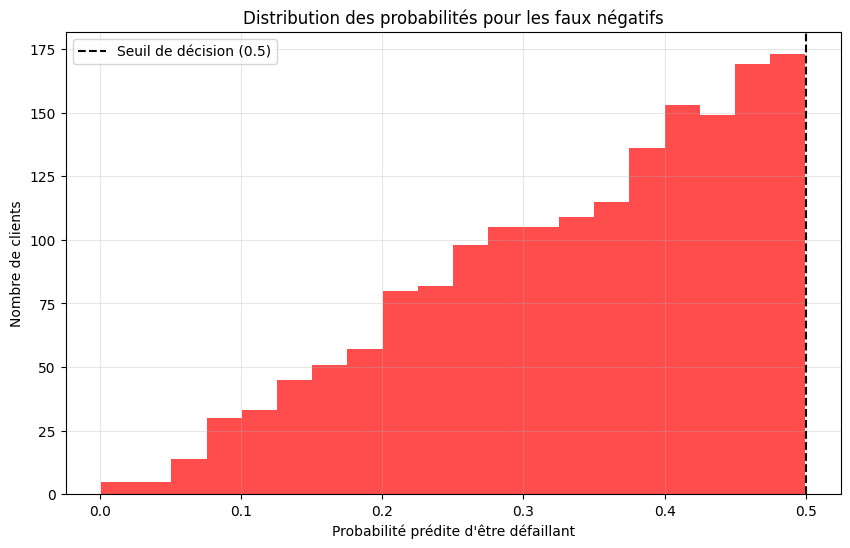

In [43]:
# Création de l'histogramme des faux négatifs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(faux_negatifs['Probabilite_Defaut'], bins=20, color='red', alpha=0.7)
plt.title('Distribution des probabilités pour les faux négatifs')
plt.xlabel('Probabilité prédite d\'être défaillant')
plt.ylabel('Nombre de clients')
plt.axvline(x=0.5, color='black', linestyle='--', label='Seuil de décision (0.5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# TEST DE DIFFERENTES VALEURS DE SEUIL AVEC RECALL COMME METRIQUE

In [44]:
from sklearn.metrics import recall_score, confusion_matrix
import numpy as np

# Obtenir les probabilités de prédiction
y_prob = model_final.predict_proba(X_test_scaled)

# Tester différents seuils
seuils = np.arange(0.2, 0.51, 0.01)
resultats = []

for seuil in seuils:
    # Prédictions avec le seuil actuel
    y_pred = (y_prob[:, 1] >= seuil).astype(int)
    # Calcul du recall
    recall = recall_score(y_test, y_pred)
    resultats.append({
        'seuil': seuil,
        'recall': recall
    })

# Afficher les résultats pour chaque seuil
for res in resultats:
    print(f"Seuil: {res['seuil']:.2f}, Recall: {res['recall']:.4f}")

# Trouver le meilleur seuil
meilleur_seuil = max(resultats, key=lambda x: x['recall'])
print(f"\nMeilleur seuil: {meilleur_seuil['seuil']:.2f} avec un recall de {meilleur_seuil['recall']:.4f}")

# Sauvegarder le meilleur modèle (avec son seuil)
meilleur_modele = {
    'model': model_final,
    'seuil': meilleur_seuil['seuil']
}

# Faire les prédictions avec le meilleur seuil
meilleures_predictions = (y_prob[:, 1] >= meilleur_seuil['seuil']).astype(int)

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, meilleures_predictions)
print("\nMatrice de confusion avec le meilleur seuil:")
print(conf_matrix)

Seuil: 0.20, Recall: 0.9519
Seuil: 0.21, Recall: 0.9460
Seuil: 0.22, Recall: 0.9392
Seuil: 0.23, Recall: 0.9323
Seuil: 0.24, Recall: 0.9275
Seuil: 0.25, Recall: 0.9192
Seuil: 0.26, Recall: 0.9130
Seuil: 0.27, Recall: 0.9031
Seuil: 0.28, Recall: 0.8947
Seuil: 0.29, Recall: 0.8858
Seuil: 0.30, Recall: 0.8781
Seuil: 0.31, Recall: 0.8697
Seuil: 0.32, Recall: 0.8608
Seuil: 0.33, Recall: 0.8522
Seuil: 0.34, Recall: 0.8403
Seuil: 0.35, Recall: 0.8350
Seuil: 0.36, Recall: 0.8264
Seuil: 0.37, Recall: 0.8159
Seuil: 0.38, Recall: 0.8056
Seuil: 0.39, Recall: 0.7946
Seuil: 0.40, Recall: 0.7845
Seuil: 0.41, Recall: 0.7724
Seuil: 0.42, Recall: 0.7595
Seuil: 0.43, Recall: 0.7486
Seuil: 0.44, Recall: 0.7364
Seuil: 0.45, Recall: 0.7235
Seuil: 0.46, Recall: 0.7108
Seuil: 0.47, Recall: 0.6953
Seuil: 0.48, Recall: 0.6822
Seuil: 0.49, Recall: 0.6703
Seuil: 0.50, Recall: 0.6548

Meilleur seuil: 0.20 avec un recall de 0.9519

Matrice de confusion avec le meilleur seuil:
[[15277 41260]
 [  239  4726]]


# MEME CHOSE MAIS AVEC LE F1 SCORE

In [45]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Obtenir les probabilités de prédiction
y_prob = model_final.predict_proba(X_test_scaled)

# Tester différents seuils
seuils = np.arange(0.2, 0.51, 0.01)
resultats = []

for seuil in seuils:
    # Prédictions avec le seuil actuel
    y_pred = (y_prob[:, 1] >= seuil).astype(int)
    # Calcul du F1-score
    f1 = f1_score(y_test, y_pred)
    resultats.append({
        'seuil': seuil,
        'f1_score': f1
    })

# Afficher les résultats pour chaque seuil
for res in resultats:
    print(f"Seuil: {res['seuil']:.2f}, F1-Score: {res['f1_score']:.4f}")

# Trouver le meilleur seuil
meilleur_seuil = max(resultats, key=lambda x: x['f1_score'])
print(f"\nMeilleur seuil: {meilleur_seuil['seuil']:.2f} avec un F1-Score de {meilleur_seuil['f1_score']:.4f}")

# Sauvegarder le meilleur modèle (avec son seuil)
meilleur_modele = {
    'model': model_final,
    'seuil': meilleur_seuil['seuil']
}

# Faire les prédictions avec le meilleur seuil
meilleures_predictions = (y_prob[:, 1] >= meilleur_seuil['seuil']).astype(int)

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, meilleures_predictions)
print("\nMatrice de confusion avec le meilleur seuil:")
print(conf_matrix)

Seuil: 0.20, F1-Score: 0.1855
Seuil: 0.21, F1-Score: 0.1886
Seuil: 0.22, F1-Score: 0.1916
Seuil: 0.23, F1-Score: 0.1948
Seuil: 0.24, F1-Score: 0.1985
Seuil: 0.25, F1-Score: 0.2020
Seuil: 0.26, F1-Score: 0.2054
Seuil: 0.27, F1-Score: 0.2083
Seuil: 0.28, F1-Score: 0.2116
Seuil: 0.29, F1-Score: 0.2150
Seuil: 0.30, F1-Score: 0.2186
Seuil: 0.31, F1-Score: 0.2220
Seuil: 0.32, F1-Score: 0.2256
Seuil: 0.33, F1-Score: 0.2293
Seuil: 0.34, F1-Score: 0.2324
Seuil: 0.35, F1-Score: 0.2373
Seuil: 0.36, F1-Score: 0.2413
Seuil: 0.37, F1-Score: 0.2449
Seuil: 0.38, F1-Score: 0.2484
Seuil: 0.39, F1-Score: 0.2519
Seuil: 0.40, F1-Score: 0.2561
Seuil: 0.41, F1-Score: 0.2601
Seuil: 0.42, F1-Score: 0.2633
Seuil: 0.43, F1-Score: 0.2677
Seuil: 0.44, F1-Score: 0.2710
Seuil: 0.45, F1-Score: 0.2745
Seuil: 0.46, F1-Score: 0.2777
Seuil: 0.47, F1-Score: 0.2802
Seuil: 0.48, F1-Score: 0.2837
Seuil: 0.49, F1-Score: 0.2876
Seuil: 0.50, F1-Score: 0.2899

Meilleur seuil: 0.50 avec un F1-Score de 0.2899

Matrice de confusion

# MEME CHOSE AVEC UN F1 SCORE PONDERE

In [46]:
from sklearn.metrics import confusion_matrix
import numpy as np

def custom_f1_score(y_true, y_pred, fn_weight=10, fp_weight=1):
    # Calcul de la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calcul de la précision et du recall pondérés
    weighted_precision = tp / (tp + fp_weight * fp) if (tp + fp_weight * fp) > 0 else 0
    weighted_recall = tp / (tp + fn_weight * fn) if (tp + fn_weight * fn) > 0 else 0
    
    # Calcul du F1-score pondéré
    if weighted_precision + weighted_recall > 0:
        weighted_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)
    else:
        weighted_f1 = 0
        
    return weighted_f1

# Test des différents seuils avec le F1-score pondéré
y_prob = model_final.predict_proba(X_test_scaled)
seuils = np.arange(0.2, 0.51, 0.01)
resultats = []

for seuil in seuils:
    y_pred = (y_prob[:, 1] >= seuil).astype(int)
    weighted_f1 = custom_f1_score(y_test, y_pred, fn_weight=10, fp_weight=1)
    resultats.append({
        'seuil': seuil,
        'weighted_f1': weighted_f1
    })

# Afficher les résultats
for res in resultats:
    print(f"Seuil: {res['seuil']:.2f}, F1-Score pondéré: {res['weighted_f1']:.4f}")

# Trouver le meilleur seuil
meilleur_seuil = max(resultats, key=lambda x: x['weighted_f1'])
print(f"\nMeilleur seuil: {meilleur_seuil['seuil']:.2f} avec un F1-Score pondéré de {meilleur_seuil['weighted_f1']:.4f}")

# Matrice de confusion pour le meilleur seuil
meilleures_predictions = (y_prob[:, 1] >= meilleur_seuil['seuil']).astype(int)
conf_matrix = confusion_matrix(y_test, meilleures_predictions)
print("\nMatrice de confusion avec le meilleur seuil:")
print(conf_matrix)

Seuil: 0.20, F1-Score pondéré: 0.1780
Seuil: 0.21, F1-Score pondéré: 0.1799
Seuil: 0.22, F1-Score pondéré: 0.1815
Seuil: 0.23, F1-Score pondéré: 0.1831
Seuil: 0.24, F1-Score pondéré: 0.1856
Seuil: 0.25, F1-Score pondéré: 0.1870
Seuil: 0.26, F1-Score pondéré: 0.1888
Seuil: 0.27, F1-Score pondéré: 0.1892
Seuil: 0.28, F1-Score pondéré: 0.1903
Seuil: 0.29, F1-Score pondéré: 0.1911
Seuil: 0.30, F1-Score pondéré: 0.1923
Seuil: 0.31, F1-Score pondéré: 0.1931
Seuil: 0.32, F1-Score pondéré: 0.1938
Seuil: 0.33, F1-Score pondéré: 0.1945
Seuil: 0.34, F1-Score pondéré: 0.1939
Seuil: 0.35, F1-Score pondéré: 0.1959
Seuil: 0.36, F1-Score pondéré: 0.1965
Seuil: 0.37, F1-Score pondéré: 0.1961
Seuil: 0.38, F1-Score pondéré: 0.1957
Seuil: 0.39, F1-Score pondéré: 0.1948
Seuil: 0.40, F1-Score pondéré: 0.1945
Seuil: 0.41, F1-Score pondéré: 0.1934
Seuil: 0.42, F1-Score pondéré: 0.1915
Seuil: 0.43, F1-Score pondéré: 0.1906
Seuil: 0.44, F1-Score pondéré: 0.1887
Seuil: 0.45, F1-Score pondéré: 0.1865
Seuil: 0.46,

In [47]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score

# Fonction pour calculer toutes les métriques
def calculer_metriques(y_true, y_pred, y_prob):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_prob[:, 1])  # AUC utilise les probabilités
    }

# Test des différents seuils
seuils = np.arange(0.2, 0.51, 0.01)
resultats = []

# L'AUC sera constant car il ne dépend pas du seuil
auc_score = roc_auc_score(y_test, y_prob[:, 1])

for seuil in seuils:
    y_pred = (y_prob[:, 1] >= seuil).astype(int)
    metriques = calculer_metriques(y_test, y_pred, y_prob)
    resultats.append({
        'seuil': seuil,
        **metriques
    })

# Afficher les résultats
print(f"AUC global (indépendant du seuil): {auc_score:.4f}\n")
print("Résultats par seuil :")
for res in resultats:
    print(f"Seuil: {res['seuil']:.2f}")
    print(f"  Accuracy: {res['accuracy']:.4f}")
    print(f"  Recall:   {res['recall']:.4f}")
    print(f"  F1-Score: {res['f1']:.4f}")
    print()

AUC global (indépendant du seuil): 0.7729

Résultats par seuil :
Seuil: 0.20
  Accuracy: 0.3252
  Recall:   0.9519
  F1-Score: 0.1855

Seuil: 0.21
  Accuracy: 0.3427
  Recall:   0.9460
  F1-Score: 0.1886

Seuil: 0.22
  Accuracy: 0.3604
  Recall:   0.9392
  F1-Score: 0.1916

Seuil: 0.23
  Accuracy: 0.3777
  Recall:   0.9323
  F1-Score: 0.1948

Seuil: 0.24
  Accuracy: 0.3955
  Recall:   0.9275
  F1-Score: 0.1985

Seuil: 0.25
  Accuracy: 0.4136
  Recall:   0.9192
  F1-Score: 0.2020

Seuil: 0.26
  Accuracy: 0.4297
  Recall:   0.9130
  F1-Score: 0.2054

Seuil: 0.27
  Accuracy: 0.4457
  Recall:   0.9031
  F1-Score: 0.2083

Seuil: 0.28
  Accuracy: 0.4619
  Recall:   0.8947
  F1-Score: 0.2116

Seuil: 0.29
  Accuracy: 0.4777
  Recall:   0.8858
  F1-Score: 0.2150

Seuil: 0.30
  Accuracy: 0.4932
  Recall:   0.8781
  F1-Score: 0.2186

Seuil: 0.31
  Accuracy: 0.5080
  Recall:   0.8697
  F1-Score: 0.2220

Seuil: 0.32
  Accuracy: 0.5228
  Recall:   0.8608
  F1-Score: 0.2256

Seuil: 0.33
  Accuracy: 0

In [48]:
import joblib
from sklearn.linear_model import LogisticRegression
import pandas as pd


# Créer le dossier models s'il n'existe pas
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Sauvegarder le modèle et le scaler
joblib.dump(model_final, 'models/credit_model.joblib')
joblib.dump(scaler, 'models/scaler.joblib')

['models/scaler.joblib']

In [49]:


# Configuration de MLflow
mlflow.set_tracking_uri("http://localhost:5000")



# Liste des modèles à tester
models_to_test = [
    # 1. Dummy Classifier (baseline)
    (DummyClassifier, {'strategy': 'stratified', 'random_state': 42}),
    
    # 2. Logistic Regression 
    (LogisticRegression, {
        'class_weight': {0:1, 1:10},
        'random_state': 42,
        'max_iter': 1000,
        'solver': 'lbfgs'
    }),
    
    # 3. Decision Tree
    (DecisionTreeClassifier, {
        'class_weight': {0:1, 1:10},
        'random_state': 42,
        'max_depth': 6,
        'min_samples_split': 10
    }),
    
    # 4. Random Forest
    (RandomForestClassifier, {
        'class_weight': {0:1, 1:10},
        'random_state': 42,
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 10,
        'n_jobs': -1
    }),
    
    # 5. XGBoost
    (XGBClassifier, {
        'scale_pos_weight': 10,
        'random_state': 42,
        'learning_rate': 0.1,
        'max_depth': 6,
        'n_estimators': 100,
        'n_jobs': -1
    }),
    
    # 6. LightGBM
    (LGBMClassifier, {
        'class_weight': {0:1, 1:10},
        'random_state': 42,
        'n_estimators': 100,
        'learning_rate': 0.1,
        'num_leaves': 32,
        'n_jobs': -1
    }),
    
    
    # 7. Gradient Boosting
    (GradientBoostingClassifier, {
    'random_state': 42,
    'n_estimators': 50,       # Réduit de 100 à 50
    'learning_rate': 0.1,
    'max_depth': 4,          # Réduit de 6 à 4
    'subsample': 0.6,        # Réduit de 0.8 à 0.6
    'min_samples_split': 100 # Ajout pour accélérer
    })
]

# Exécution des modèles
try:
    results = []
    for model_class, params in models_to_test:
        try:
            model, metrics, _ = train_and_evaluate_model(
                model_class(),
                X_train_scaled,
                X_test_scaled,
                y_train,
                y_test,
                model_params=params,
                seuil=0.36
            )
            results.append((model_class.__name__, metrics))
        except Exception as e:
            print(f"Erreur avec {model_class.__name__}: {str(e)}")
            continue

    # Analyse comparative
    print("\nComparatif des performances :")
    for name, metrics in results:
        print(f"\n{name}:")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")

except Exception as e:
    print(f"Erreur générale: {str(e)}")
finally:
    if mlflow.active_run():
        mlflow.end_run()

2025/02/21 06:54:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour DummyClassifier:
accuracy: 0.8533
recall: 0.0860
f1_score: 0.0865
auc_score: 0.5033
custom_credit_score: 0.0168
🏃 View run DummyClassifier at: http://localhost:5000/#/experiments/713072862009697132/runs/4ba0706d58d148568e08449ba442a97a
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132


2025/02/21 06:55:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour LogisticRegression:
accuracy: 0.5803
recall: 0.8244
f1_score: 0.2408
auc_score: 0.7728
custom_credit_score: 0.1956
🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/713072862009697132/runs/73210580af284e52b4362baf083a8450
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132


2025/02/21 06:56:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour DecisionTreeClassifier:
accuracy: 0.5227
recall: 0.7841
f1_score: 0.2096
auc_score: 0.7132
custom_credit_score: 0.1664
🏃 View run DecisionTreeClassifier at: http://localhost:5000/#/experiments/713072862009697132/runs/3398e257a0dc406aa5dfc5165fec6d37
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132


2025/02/21 06:57:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour RandomForestClassifier:
accuracy: 0.4910
recall: 0.8562
f1_score: 0.2136
auc_score: 0.7453
custom_credit_score: 0.1839
🏃 View run RandomForestClassifier at: http://localhost:5000/#/experiments/713072862009697132/runs/ada76c0bc4f74b85ab4ea502b8bdd38b
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132


2025/02/21 06:58:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour XGBClassifier:
accuracy: 0.6173
recall: 0.8034
f1_score: 0.2531
auc_score: 0.7806
custom_credit_score: 0.1980
🏃 View run XGBClassifier at: http://localhost:5000/#/experiments/713072862009697132/runs/15518f70efa2492db1f27cfa6ad24ee1
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.123906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99361
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 730
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


2025/02/21 06:59:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour LGBMClassifier:
accuracy: 0.6121
recall: 0.8111
f1_score: 0.2524
auc_score: 0.7843
custom_credit_score: 0.1996
🏃 View run LGBMClassifier at: http://localhost:5000/#/experiments/713072862009697132/runs/269aaac461644c3eb56c18fee6724cae
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132


2025/02/21 07:13:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour GradientBoostingClassifier:
accuracy: 0.9185
recall: 0.0667
f1_score: 0.1167
auc_score: 0.7686
custom_credit_score: 0.0140
🏃 View run GradientBoostingClassifier at: http://localhost:5000/#/experiments/713072862009697132/runs/885056ea62814f0aa437bffef1e20afc
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132

Comparatif des performances :

DummyClassifier:
accuracy: 0.8533
recall: 0.0860
f1_score: 0.0865
auc_score: 0.5033
custom_credit_score: 0.0168

LogisticRegression:
accuracy: 0.5803
recall: 0.8244
f1_score: 0.2408
auc_score: 0.7728
custom_credit_score: 0.1956

DecisionTreeClassifier:
accuracy: 0.5227
recall: 0.7841
f1_score: 0.2096
auc_score: 0.7132
custom_credit_score: 0.1664

RandomForestClassifier:
accuracy: 0.4910
recall: 0.8562
f1_score: 0.2136
auc_score: 0.7453
custom_credit_score: 0.1839

XGBClassifier:
accuracy: 0.6173
recall: 0.8034
f1_score: 0.2531
auc_score: 0.7806
custom_credit_score: 0.1980

LGBMClassifier:
accuracy: 0.6121
reca

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.599145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99361
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 730
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


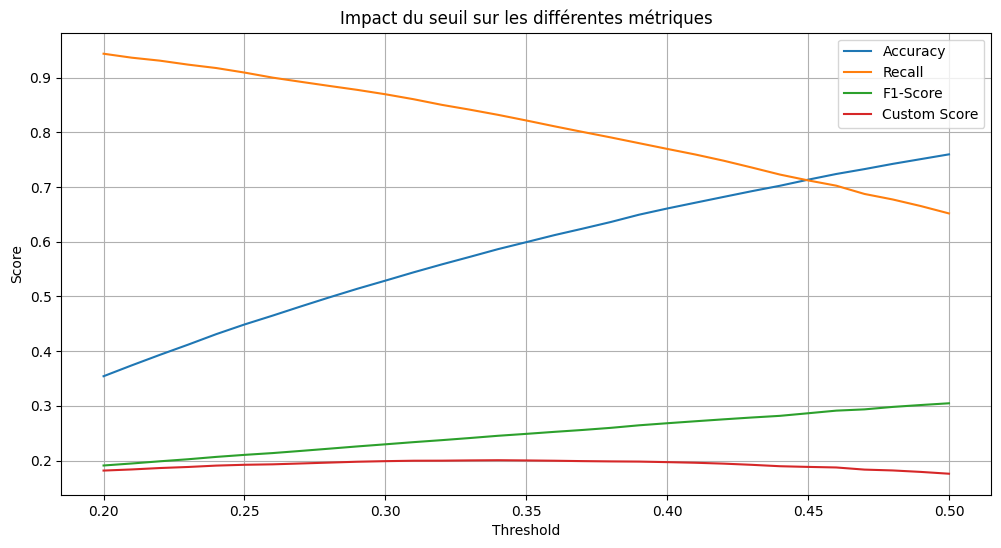


Meilleurs seuils par métrique:
accuracy: 0.500
recall: 0.200
f1_score: 0.500
custom_credit_score: 0.340


In [50]:
# Création et entraînement du modèle LightGBM
lgbm_model = LGBMClassifier(
    class_weight={0:1, 1:10},
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=32,
    n_jobs=-1
)
X_train_scaled = clean_feature_names(X_train_scaled)
X_test_scaled = clean_feature_names(X_test_scaled)
# Entraînement du modèle
lgbm_model.fit(X_train_scaled, y_train)

# Fonction de test des seuils
def test_thresholds(model, X_test, y_test, start=0.2, end=0.5, step=0.01):
    # Obtenir les probabilités
    y_prob = model.predict_proba(X_test)
    
    thresholds = np.arange(start, end + step, step)
    results = []
    
    for threshold in thresholds:
        # Appliquer le seuil
        y_pred = (y_prob[:, 1] >= threshold).astype(int)
        
        # Calculer toutes les métriques
        metrics = {
            'threshold': threshold,
            'accuracy': accuracy_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'custom_credit_score': custom_credit_score(y_test, y_pred, fn_weight=10, fp_weight=1)
        }
        results.append(metrics)
    
    # Convertir en DataFrame pour une meilleure visualisation
    results_df = pd.DataFrame(results)
    
    # Trouver le meilleur seuil pour chaque métrique
    best_thresholds = {
        'accuracy': results_df.loc[results_df['accuracy'].idxmax(), 'threshold'],
        'recall': results_df.loc[results_df['recall'].idxmax(), 'threshold'],
        'f1_score': results_df.loc[results_df['f1_score'].idxmax(), 'threshold'],
        'custom_credit_score': results_df.loc[results_df['custom_credit_score'].idxmax(), 'threshold']
    }
    
    return results_df, best_thresholds

# Test des différents seuils
results_df, best_thresholds = test_thresholds(lgbm_model, X_test_scaled, y_test)

# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(results_df['threshold'], results_df['accuracy'], label='Accuracy')
plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
plt.plot(results_df['threshold'], results_df['f1_score'], label='F1-Score')
plt.plot(results_df['threshold'], results_df['custom_credit_score'], label='Custom Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Impact du seuil sur les différentes métriques')
plt.legend()
plt.grid(True)
plt.show()

# Afficher les meilleurs seuils
print("\nMeilleurs seuils par métrique:")
for metric, threshold in best_thresholds.items():
    print(f"{metric}: {threshold:.3f}")

In [51]:
results_df

,threshold,accuracy,recall,f1_score,custom_credit_score
0,0.20,0.354119,0.943807,0.190895,0.181607
1,0.21,0.373988,0.936556,0.194557,0.183664
2,0.22,0.393239,0.931118,0.198570,0.186257
3,0.23,0.411840,0.923867,0.202307,0.188188
4,0.24,0.431092,0.917623,0.206617,0.190699
5,0.25,0.448717,0.909366,0.210318,0.192189
6,0.26,0.464944,0.900101,0.213598,0.193008
7,0.27,0.481740,0.892447,0.217547,0.194590
8,0.28,0.498114,0.884995,0.221611,0.196187
9,0.29,0.513951,0.877744,0.225750,0.197767


In [52]:
from itertools import product
import numpy as np
import lightgbm as lgb

def custom_lgb_score(preds, train_data):
    y_true = train_data.get_label()
    y_pred = (preds >= 0.34).astype(int)
    score = custom_credit_score(y_true, y_pred, fn_weight=10, fp_weight=1)
    return 'custom_credit_score', score, True

# Configuration des paramètres
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [ 0.1, 0.2], 
    'num_leaves': [31, 62],
    'max_depth': [5, 7]
}

param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
results = []

for params in param_combinations:
    print(f"\nTest des paramètres: {params}")
    
    fold_scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in skf.split(X_train_scaled, y_train):
        # Utiliser .iloc pour les DataFrames
        X_fold_train = X_train_scaled.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train_scaled.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Créer et entraîner le modèle
        model = lgb.LGBMClassifier(
            **params,
            objective='binary',
            scale_pos_weight=10
        )
        
        model.fit(X_fold_train, y_fold_train)
        
        # Prédictions
        y_pred_proba = model.predict_proba(X_fold_val)
        y_pred = (y_pred_proba[:, 1] >= 0.34).astype(int)
        
        # Score
        score = custom_credit_score(y_fold_val, y_pred, fn_weight=10, fp_weight=1)
        fold_scores.append(score)
    
    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    
    results.append({
        'params': params,
        'mean_score': mean_score,
        'std_score': std_score
    })
    
    print(f"Score moyen: {mean_score:.4f} (±{std_score:.4f})")

# Meilleurs paramètres
best_result = max(results, key=lambda x: x['mean_score'])

print("\nMeilleurs paramètres trouvés:")
print(best_result['params'])
print(f"\nMeilleur score: {best_result['mean_score']:.4f} (±{best_result['std_score']:.4f})")

# Résultats triés
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('mean_score', ascending=False)
print("\nTous les résultats triés par score:")
print(results_df)


Test des paramètres: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 5}
[LightGBM] [Info] Number of positive: 15888, number of negative: 180916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.180986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99256
[LightGBM] [Info] Number of data points in the train set: 196804, number of used features: 729
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.274219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99361
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 730
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


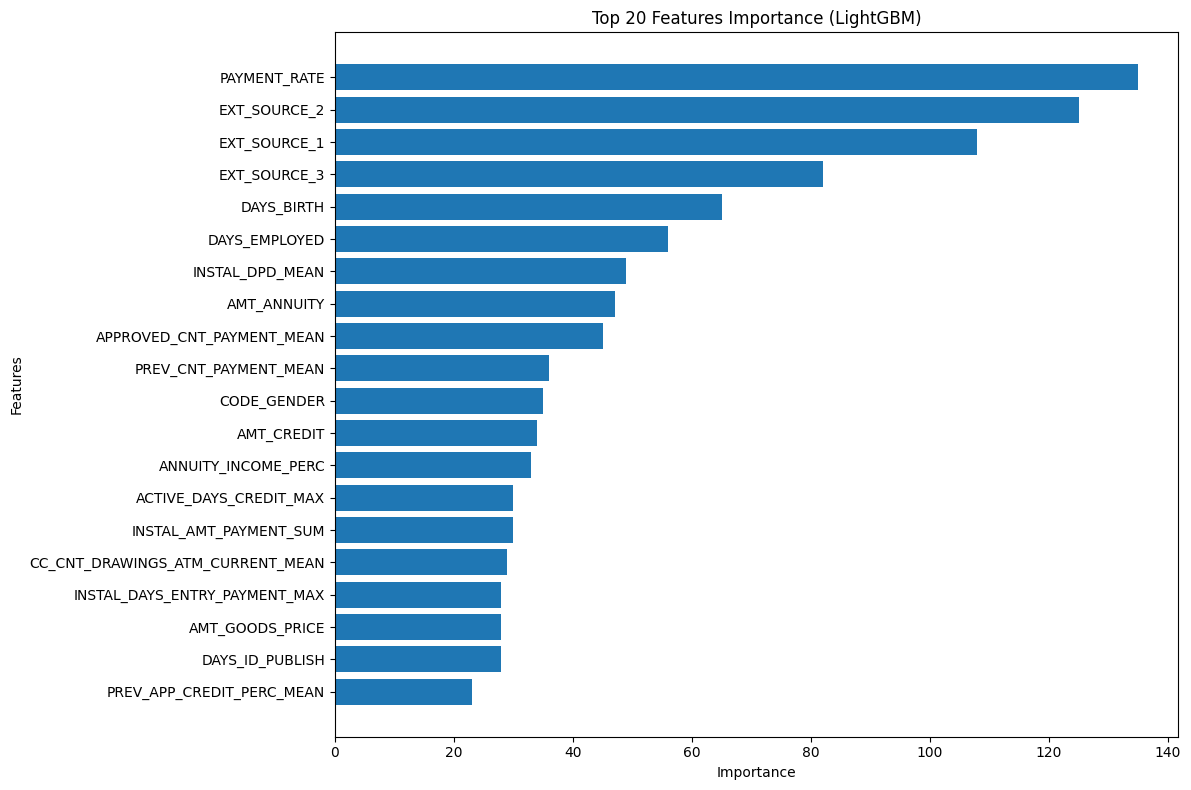


Top 20 features les plus importantes:
                              feature  importance
244                      PAYMENT_RATE         135
31                       EXT_SOURCE_2         125
30                       EXT_SOURCE_1         108
32                       EXT_SOURCE_3          82
9                          DAYS_BIRTH          65
10                      DAYS_EMPLOYED          56
630                   INSTAL_DPD_MEAN          49
6                         AMT_ANNUITY          47
578         APPROVED_CNT_PAYMENT_MEAN          45
389             PREV_CNT_PAYMENT_MEAN          36
0                         CODE_GENDER          35
5                          AMT_CREDIT          34
243               ANNUITY_INCOME_PERC          33
649            INSTAL_AMT_PAYMENT_SUM          30
308            ACTIVE_DAYS_CREDIT_MAX          30
721  CC_CNT_DRAWINGS_ATM_CURRENT_MEAN          29
7                     AMT_GOODS_PRICE          28
650     INSTAL_DAYS_ENTRY_PAYMENT_MAX          28
12         

In [53]:
import matplotlib.pyplot as plt

# Créer et entraîner le meilleur modèle
best_model = lgb.LGBMClassifier(
    n_estimators=best_result['params']['n_estimators'],
    learning_rate=best_result['params']['learning_rate'],
    num_leaves=best_result['params']['num_leaves'],
    max_depth=best_result['params']['max_depth'],
    class_weight={0:1, 1:10},
    random_state=42
)

best_model.fit(X_train_scaled, y_train)

# Feature Importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=True).tail(20)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Top 20 Features Importance (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Afficher aussi les valeurs numériques
print("\nTop 20 features les plus importantes:")
print(feature_importance.sort_values('importance', ascending=False))

c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.370719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99361
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 730
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


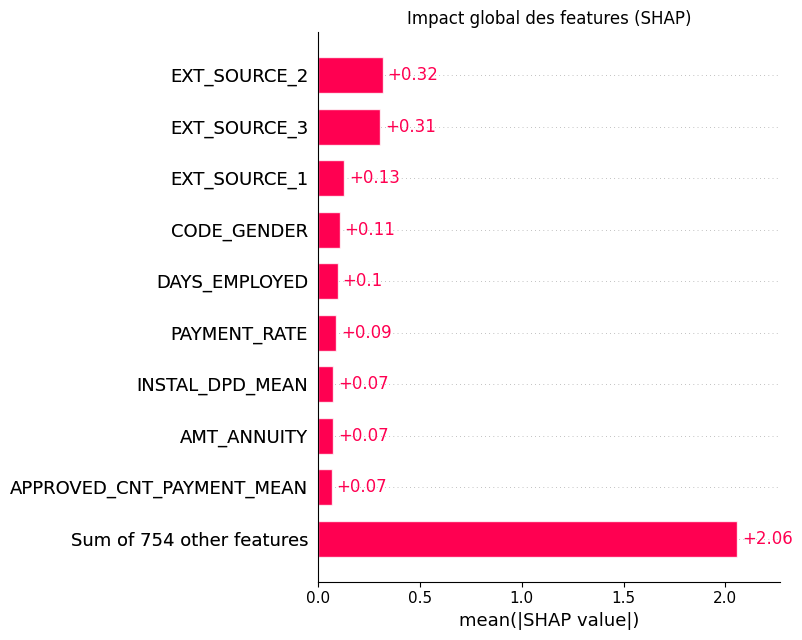

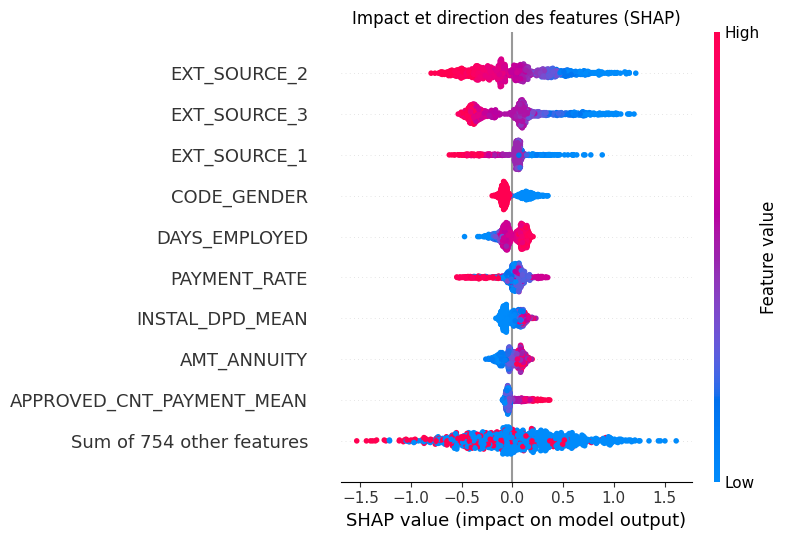

In [54]:
import shap

# Créer et entraîner le meilleur modèle
best_model = lgb.LGBMClassifier(
    n_estimators=best_result['params']['n_estimators'],
    learning_rate=best_result['params']['learning_rate'],
    num_leaves=best_result['params']['num_leaves'],
    max_depth=best_result['params']['max_depth'],
    class_weight={0:1, 1:10},
    random_state=42
)

best_model.fit(X_train_scaled, y_train)

# Créer l'explainer SHAP
explainer = shap.TreeExplainer(best_model)

# Calculer les valeurs SHAP (avec un échantillon pour accélérer)
# Utiliser un échantillon plus petit si nécessaire
sample_size = min(1000, len(X_train_scaled))
sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample = X_train_scaled.iloc[sample_indices]

# Nouvelle méthode pour obtenir les SHAP values
shap_values = explainer(X_sample)

# Plot résumé des SHAP values (nouveau format)
plt.figure(figsize=(10, 8))
shap.plots.bar(shap_values, show=False)
plt.title("Impact global des features (SHAP)")
plt.tight_layout()
plt.show()

# Plot détaillé
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(shap_values, show=False)
plt.title("Impact et direction des features (SHAP)")
plt.tight_layout()
plt.show()

In [55]:
import joblib
import os

# Créer le dossier models s'il n'existe pas
if not os.path.exists('models'):
    os.makedirs('models')

# Créer et entraîner le meilleur modèle
best_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=7,
    class_weight={0:1, 1:10},
    random_state=42
)

# Entraîner le modèle sur l'ensemble du jeu d'entraînement
best_model.fit(X_train_scaled, y_train)

# Sauvegarder le modèle et le scaler
joblib.dump(best_model, 'models/lgbm_model.joblib')
joblib.dump(scaler, 'models/scaler.joblib')

print("Modèle et scaler sauvegardés avec succès dans le dossier 'models'")

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.677452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99361
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 730
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884
Modèle et scaler sauvegardés avec succès dans le dossier 'models'
